In [1]:
import os

import pandas as pd
import numpy as np
import tensorflow as tf

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.model import rnn_regression_model, compile_model
from rna_learn.transform import sequence_embedding
from rna_learn.load import load_rna_structure_dataset

In [2]:
model = rnn_regression_model(alphabet_size=3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 3)      0           sequence[0][0]                   
__________________________________________________________________________________________________
gru (GRU)                       (None, 100)          31500       masking[0][0]                    
__________________________________________________________________________________________________
logits (Dense)                  (None, 100)          10100       gru[0][0]                        
______________________________________________________________________________________________

In [3]:
compile_model(model, learning_rate=1e-4)

In [4]:
alphabet=['.', '(', ')']
sequences = [
    '..................(((',
    '...((((...)))).((((((((.(((.....)',
]
x = sequence_embedding(sequences, alphabet)
x.shape

(2, 33, 3)

In [5]:
model(x).mean()

<tf.Tensor: id=2689, shape=(2, 1), dtype=float32, numpy=
array([[-0.07895306],
       [-0.04923508]], dtype=float32)>

In [6]:
%%time
sequences, metadata = load_rna_structure_dataset('data/tab/mrna.tab', 'data/seq/')

CPU times: user 613 ms, sys: 302 ms, total: 915 ms
Wall time: 927 ms


In [7]:
metadata.head()

,sp,taxid,temp.cat,rna.type,temp,length,gc,paired,asa,sd.asa,maxmin.asa,mfe,mfe1,mfe2,mfe3,category
0,Achromobacter denitrificans,32002,mRNA eno,mesophile,30,1281,0.711944,0.685402,159.123952,16.743722,112.4710,-687.0,-116.113844,-257.076746,-44.467685,mRNA eno
1,Acidithiobacillus ferrooxidans,920,mRNA eno,mesophile,31,1281,0.578454,0.661983,171.630226,11.805094,98.4460,-515.9,-84.663969,-85.976746,-13.017809,mRNA eno
2,Actinobacillus pleuropneumoniae,715,mRNA eno,mesophile,37,1311,0.421053,0.607170,141.066765,18.037808,127.2285,-369.0,-102.429906,71.401738,-20.539147,mRNA eno
3,Actinobacillus suis,716,mRNA eno,mesophile,37,1311,0.397407,0.639207,143.607326,18.291201,132.1183,-369.4,-127.567266,71.001738,-45.676507,mRNA eno
4,Aequorivita sublithincola,101385,mRNA eno,psychrophile,4,1287,0.397824,0.581197,177.095760,11.562361,90.4570,-323.9,-81.630144,108.118951,-7.935065,mRNA eno


In [13]:
print(sequences[0])
metadata.iloc[0]

..................(((((((..((.(((((((((((((((((....(((((((((((.(((((((..((((....((((((((((...(((...)))..)))))))))))))))))))))(((((.((((...((((.(((((((.(((.((....)).)))))))).)).))))..((((((((((((((((..((((.((((....)))).))))))))))((..(((((((((....))))...))))).))((((.((((.((.....)).)))).)))).)))))))))).......((((((.(((((....))))).)).))))..(((((((((((((((.......))))))....))))))))).((((((((((((((.....((((((((((....))..)))))))))))))).(((((....)))))..)))))))))))).))))).........)))))...(((((........)))))..))))))((((((.....))))))..((((.......))))(((.((((((...)))))))))((((((((((...)).)))))))).((((((...((.(((((.((...(((((.(((...))).))))).)).)))))))...)))))).............((.((((((((((((((((((((.(((..((.((((......(((((((((((....))).)))))))).......((((((...)))))).((((.....))))...((((((((..((....))..)))))))).)))).)).))))))))))))))))(((.........)))))))))).)).((((...))))(((((.((((((((.((((.......(((((((...)))))))))))(((((((....))))))))))))))))))))........))))))))).)))))...))).))((((((((...((....))...)))

sp            Achromobacter denitrificans
taxid                               32002
temp.cat                         mRNA eno
rna.type                        mesophile
temp                                   30
length                               1281
gc                               0.711944
paired                           0.685402
asa                               159.124
sd.asa                            16.7437
maxmin.asa                        112.471
mfe                                  -687
mfe1                             -116.114
mfe2                             -257.077
mfe3                             -44.4677
category                         mRNA eno
Name: 0, dtype: object

In [14]:
%%time
x = sequence_embedding(sequences, alphabet)
x.shape

CPU times: user 11.4 s, sys: 823 ms, total: 12.3 s
Wall time: 12.4 s


(9624, 4725, 3)

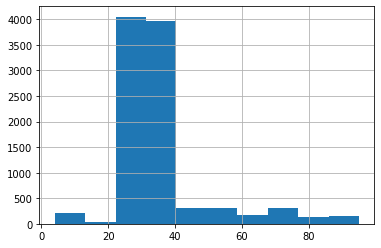

In [21]:
y = metadata['temp']
y.hist();